<a href="https://colab.research.google.com/github/AdityaDesai006/Multitask-Classifier-with-Keras/blob/main/Multi_Task_Models_With_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Importing Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
def create_example(x, y):
  c = np.random.randint(0, 2)
  image = 0.5 * np.random.rand(28, 28, 3) #dimensions of image in dataset
  image[:, :, c] += 0.5 * x / 255
  return image, y, c

In [ ]:
colors = {0: 'red', 1:'green'}

x, y, c = create_example(x_train[3], y_train[3]) #printing image in rgb with noise
print(f'digit: {y}, color: {colors[c]}')

digit: 1, color: red


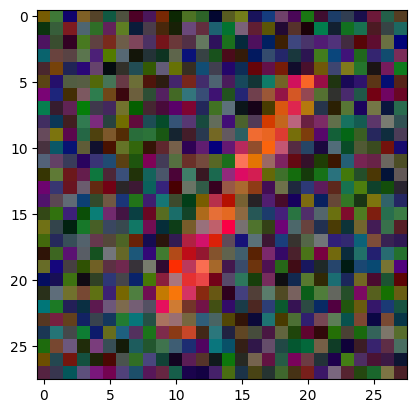

In [ ]:
plt.imshow(x)
plt.show()

## Dataset Generator

In [ ]:
#will be used for training and testing
def generate_data(x, y, batch_size=32):
  num_examples = len(y)

  while True:      #used to figure out batch values ie examples and labels and yield results
    x_batch = np.zeros((batch_size, 28, 28, 3))
    y_batch = np.zeros((batch_size,)) #y labels would be from 0-9
    c_batch = np.zeros((batch_size,)) #colors info will be from 0 - 1

    for i in range(0, batch_size):  #used to generate exaples and populate the x, y, c batches
      index= np.random.randint(0, num_examples)
      image, digit, color = create_example(x[index], y[index])
      x_batch[i] = image
      y_batch[i] = digit
      c_batch[i] = color

    yield x_batch, [y_batch, c_batch] #x_batch will be the single input for which, y_batch and c_batch are outputs


[8.] [1.]


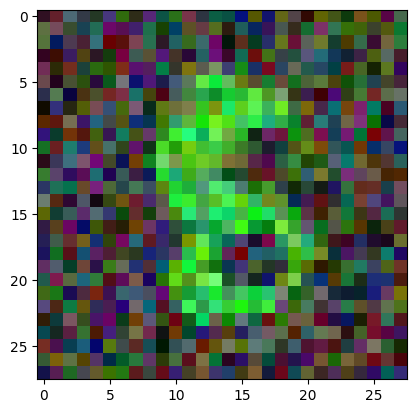

In [ ]:
x, [y, c] = next(generate_data(x_test, y_test, batch_size = 1))
print(y, c)
plt.imshow(x[0])


## Building Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(28, 28, 3), name = 'Input') #input for conv

conv_1 = Conv2D(32, 3, name = 'Conv1')(input_) #input for activation, default padding value = valid
act_1 = Activation('relu', name = 'Activation_1')(conv_1)

pool_1 = MaxPool2D(4, name='Pool_1')(act_1)
flat_1 = Flatten(name='Flat_1')(pool_1)

color = Dense(1, activation='sigmoid', name='color')(flat_1) #predictor of the color, since only 2 colors, single layer

conv_2 = Conv2D(32, 3, padding='same', name='conv_2')(act_1)
act_2 = Activation('relu', name='Activation_2')(conv_2)

conv_3 = Conv2D(32, 3, padding='same', name='conv_3')(act_2)
add = Add(name='Add')([act_1, conv_3]) #skip connection
act_3 = Activation('relu', name='act_3')(add)

pool_2 = MaxPool2D(4, name='pool_2')(act_3)
flat_2 = Flatten(name='flat_2')(pool_2)

#output for digits
digit = Dense(10, activation='softmax', name='digit')(flat_2) #since only 10 digits are there

model = tf.keras.models.Model(input_, [digit, color])

model.compile(
    loss = {
        'digit': 'sparse_categorical_crossentropy',
        'color': 'binary_crossentropy'
    },
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 26, 26, 32)           896       ['Input[0][0]']               
                                                                                                  
 Activation_1 (Activation)   (None, 26, 26, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 conv_2 (Conv2D)             (None, 26, 26, 32)           9248      ['Activation_1[0][0]']        
                                                                                            

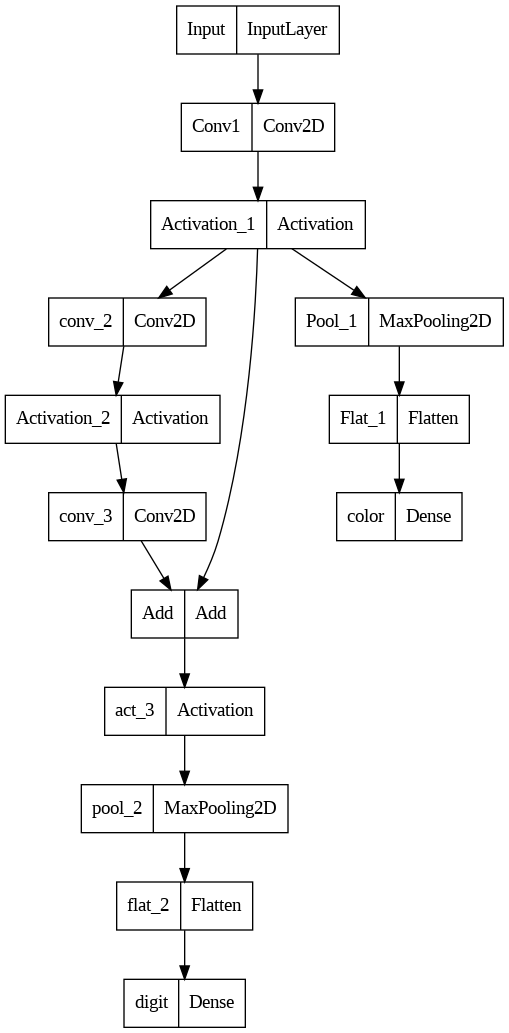

In [ ]:
tf.keras.utils.plot_model(model)

## Training the Model

In [ ]:
class Logger(tf.keras.callbacks.Callback):  #creating keras callback
  def on_epoch_end(self, epoch, logs=None):    #will extract values for digit and color accuracy
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [ ]:
train_gen = generate_data(x_train, y_train)
test_gen = generate_data(x_test, y_test)

_ = model.fit(train_gen, validation_data = test_gen, steps_per_epoch = 200, epochs = 10, validation_steps = 100, callbacks=[Logger(), tf.keras.callbacks.TensorBoard(log_dir='./logs')], verbose = False)

============================== 1 ==============================
digit_accuracy: 0.50, color_accuracy: 0.95
val_digit_accuracy: 0.82, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.84, color_accuracy: 1.00
val_digit_accuracy: 0.90, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.91, color_accuracy: 1.00
val_digit_accuracy: 0.94, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.94, color_accuracy: 1.00
val_digit_accuracy: 0.95, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.94, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.95, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 7 ===================

In [ ]:
# %tensorboard --logdir logs

## Final Predictions

In [ ]:
def test_model(show=True):
  x, [y, c] = next(test)  #fetching next example and labels

  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])  #since output is probability distribution using argmax for digit
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])

  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)  #instantiating a test data generator

1/1 [==============================] - 0s 74ms/step
GT: 7, red
Pr: 7, red


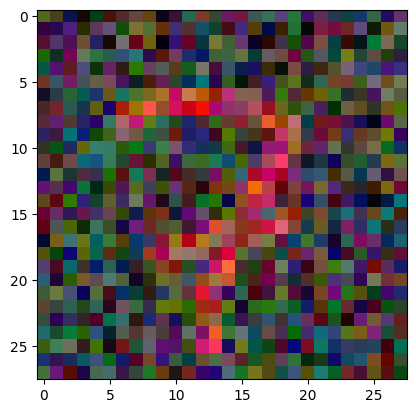

In [ ]:
test_model()

## Multiple Predictor

1/1 [==============================] - 0s 19ms/step


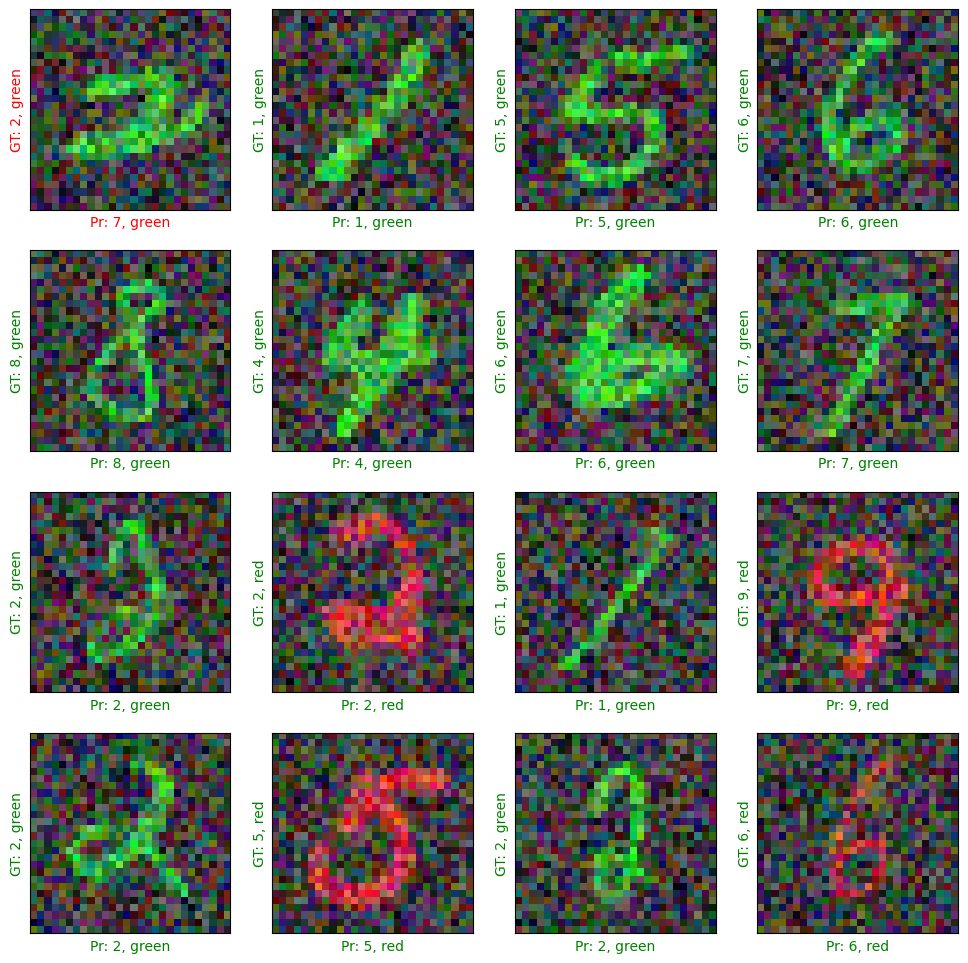

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 16):
  plt.subplot(4, 4, i+1)
  test_model(show=False) #show is false as we dont want to display individual images

plt.show()